In [1]:
import math
import time
from datetime import datetime
import os

import numpy as np
import pandas as pd
from pandarallel import pandarallel
# Initialization
pandarallel.initialize()

import matplotlib.pyplot as plt
import matplotlib.patches
from matplotlib.path import Path
import matplotlib.patches as mpatches

import scipy.stats

from skimage import measure
from skimage import morphology
from skimage.morphology import convex_hull_image, erosion
from skimage import data, img_as_float
from skimage.util import invert

%matplotlib inline

%run py/constants.py
%run py/take_processing_methods.py
%run py/marker_processing_methods.py
%run py/heatmap_methods.py
%run py/grasp_property_methods.py
%run py/rasterization_methods.py

INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
devices = ['s3', 's4', 'opo', 'n6']
fingers = ["Thumb", "Index", "Middle", "Ring", "Little"]
colors = ["#FF523E","#188D6C","#6499FF","#FFAC33"]
tasks = ["WRITE", "READ", "Fitts"]
joints = ["Fn", "DIP", "PIP", "MCP"]

In [3]:
def getDeviceCorners(device):
    rb_edge = (heatmap_size_x - 50, heatmap_size_y - 50)
    device_width_px = get_device_size(device)[0] / 0.001
    device_height_px = get_device_size(device)[1] / 0.001
    x = [rb_edge[0] - device_width_px, rb_edge[0], rb_edge[0], rb_edge[0] - device_width_px, rb_edge[0] - device_width_px]
    y = [rb_edge[1] - device_height_px, rb_edge[1] - device_height_px, rb_edge[1], rb_edge[1], rb_edge[1] - device_height_px]
    return x, y

def fillContour(contour_points, output_size):
    mask = np.ones(output_size)
    points = np.argwhere(mask)
    
    if (len(contour_points) == 0):
        return np.zeros(output_size)
    
    path = Path(contour_points)
    poly_mask = path.contains_points(points)
    return poly_mask.reshape(output_size)

def getContourFromImg(img, level):
    contours = measure.find_contours(img, level)
    points_to_approx = []
    highest_val = 0
    for n, contour in enumerate(contours):
        if (len(contour) > highest_val):
            points_to_approx = contour
            highest_val = len(contour) 
            
    return points_to_approx

def getConvexHull(img):
    filtered = np.array(img, copy=True)

#     mean_visited = filtered[filtered > 0].mean()
#     filtered[filtered < mean_visited] = 0
    
#     filtered = cv2.blur(filtered,(5,5))
#     filtered = cv2.threshold(filtered, 1, 250, cv2.THRESH_BINARY)
#     filtered = filtered[1]
    
    img = filtered.copy(order='C')
    img[img > 0] = 1
    
    if (img.sum() > 0):
        return convex_hull_image(img)
    else:
        return np.zeros(img.shape)
    
def generateComfAreaTable(cs):
    """ 
        Creates latex tables in the following style
        Thumb - \textbf{$F_0$} & 33.6 & 41.9 & 35.2 & 35.0 & 36.4  & 3.3 \\
        Index Finger - \textbf{$F_1$} & 30.8 & 37.3 & 48.9 & 47.6 & 41.1  & 7.5 \\
        Middle Finger -\textbf{$F_2$} & 24.6 & 28.5 & 35.3 & 36.7 & 31.3  & 5.0 \\
        Ring Finger -  \textbf{$F_3$} & 15.8 & 11.7 & 18.0 & 22.0 & 16.9  & 3.7  \\
        Little Finger -\textbf{$F_4$} & 16.9 & 16.0 & 20.5 & 23.7 & 19.3  & 3.1 \\
    """
    
    
    begin_part = '''\\begin{table}[b!]
    \\centering
    \\small
    \\begin{tabularx}{\\columnwidth}{rrrrrrr}
    \\toprule
        & \\textbf{S3}   & \\textbf{S4}   & \\textbf{OPO}  & \\textbf{N6}   & \\textbf{Mean} & \\textbf{SD}   \\\\
                    \\midrule'''
    
    end_part = '''    \\bottomrule
    \\end{tabularx}
    \\caption{Comfortable areas in $cm^2$ for all fingers on four devices.}
    \\label{table:ellipse_size}
\\end{table}'''
    rows = ["Thumb", "Index Finger", "Middle Finger", "Ring Finger", "Little Finger"]
    cs = np.array(cs, copy=True)
    
    latex = ""
    print(begin_part)
    for i in range(len(rows)):
        line = "        " + rows[i] + " - \\textbf{$F_" + str(i) + "$} & "
        line = line + " & ".join(["%.1f" % (num/100) for num in cs[i,:]])
        line = line + " & " + ("%.1f" % (cs[i,:].mean() / 100)) + " & " + ("%.1f" % (cs[i,:].std() / 100)) + " \\\\"
        print(line)
    print(end_part)
    
    
def getHeatmapCenters(device, joint):
    """
    Get means of the heatmaps for device and joint. 
    To get the total mean for a device and joint, call
    
    x, y = getHeatmapCenters(device, joint)
    x.mean(), y.mean()
    """
    
    
    heatmaps = getOriginals(device) 
    means = []
    for i in range(len(heatmaps)):
        jointLittleMcp = getJointIndex(joint)
        side = 0 if ('Thumb' in joint) else 1
        mcpHeatmap = heatmaps[devices.index(device)][i][jointLittleMcp][side].T

        o_x, o_y = np.argwhere(mcpHeatmap.T > 0).T
        if (len(o_x) > 0 and len(o_y) > 0):
            means.append([o_x.mean(), o_y.mean()])

    means = np.array(means)
    
    return means[:, 0], means[:, 1]

# Create DF holding important information

In [4]:
%%time
def getJointIndex(s):
    parts = s.split("_")
    return fingers.index(parts[0]) * 4 + joints.index(parts[1])


heatmaps = []
originals = []

pd_table = []
print("Reading in files...")
for cond in ["seated", "walking"]:
    for task in tasks:
        print("Working on condition %s and task %s" % (cond,task))
        directory = "./heatmaps/%s/%s_highres/"%(cond, task)
        for filename in os.listdir(directory):
            if not filename.endswith(".npy"):
                continue
            
            participant = filename.split("_")[0].replace("P","")
            device = filename.split("_")[1]
            heatmaps = np.load(directory + filename, allow_pickle = True)
            
            for f in range(len(fingers)):
                side = 0 if ('Thumb' in fingers[f]) else 1
                for j in range(len(joints)):
                    jointIdx = getJointIndex(fingers[f] + "_" + joints[j])
                    hm = heatmaps[jointIdx][side].T

                     # calculating center
                    nz = np.argwhere(hm.T) 
                    x = nz[:, 0]
                    y = nz[:, 1]
                    center_x = x.mean()
                    center_y = y.mean()
                    row = [device, cond, task, fingers[f], joints[j], participant, hm, center_x, center_y]
                    pd_table.append(row)
                    
df = pd.DataFrame(pd_table, columns=["Device", "Condition","Task", "Finger", "Joint", "Participant", "Raw", "Center_X", "Center_Y"])

print("Calculate filling contour ... ")
#Calculate filled contour for each heatmap
df['FilledContour'] = df.Raw.parallel_apply(lambda x : fillContour(getContourFromImg(x, 3), (260, 185)).astype(int))
print("Calculate convex hull ... ")
# Calculate convex hull for each heatmap
df['ConvexHull'] = df.Raw.parallel_apply(lambda x : getConvexHull(x).astype(int))
print("Saving to ./Pickles/pd_comfortable_zones")
df.to_pickle("./Pickles/pd_comfortable_zones.pkl")

Reading in files...
Working on condition seated and task WRITE


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice.


Working on condition seated and task READ
Working on condition seated and task Fitts
Working on condition walking and task WRITE
Working on condition walking and task READ
Working on condition walking and task Fitts
Calculate filling contour ... 
Calculate convex hull ... 
Saving to ./Pickles/pd_comfortable_zones
CPU times: user 12.7 s, sys: 1min 9s, total: 1min 22s
Wall time: 1min 44s


In [5]:
df = pd.read_pickle("./Pickles/pd_comfortable_zones.pkl")

In [6]:
comfortable_areas_paper = np.load("./data_from_Le_CHI18/unions.npy")
finger_comfortable_areas_paper = np.load("./data_from_Le_CHI18/all_comf_areas.npy")

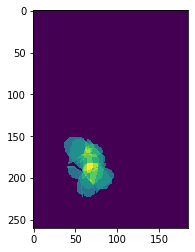

In [7]:
plt.imshow(finger_comfortable_areas_paper[4][3])

In [8]:
%%time
def getNewComfArea(raw):
    ################### ORIGINAL #####################
    img = np.array(raw, copy = True)
    ################### ORIGINAL #####################


    ################### FILTERED #####################
    #cell_id = 1
    #mean = raw[raw > 0].mean()
    step1 = img#np.array(img, copy = True)
    step1[step1 < 2] = 0
    step1[step1 > 0] = 1
    ################### FILTERED #####################


    ################### NOISE REMOVAL #####################
    #cell_id = 2
    #step2 = np.array(step1, copy=True).astype(bool)
    #step2 = morphology.remove_small_objects(step2, min_size=5, connectivity=300)
    ################### NOISE REMOVAL #####################


    ################### DILATION #####################
    #cell_id = 3
    #step3 = np.array(step2, copy=True,  dtype=np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    #step3 = cv2.dilate(step3, kernel)
    #step3 = cv2.erode(step3, kernel)
    ################### DILATION #####################


    ################### CONTOUR #####################
    #cell_id = 4
    #step4 = np.array(step1, copy=True)
    contours = measure.find_contours(step1, 0)
    ################### CONTOUR #####################


    ################### FILLED CONTOUR #####################
    #cell_id = 5
    #step5 = step4#np.array(step4, copy=True)
    step5 = np.zeros(step1.shape).astype(np.uint8)

    for n, contour in enumerate(contours):
        if (len(contour) > 0):
            filled = fillContour(contour, step5.shape)
        step5 = step5 + filled
    ################### FILLED CONTOUR #####################
    return step5.astype(np.uint8)

df['NewComfArea'] = df.Raw.parallel_apply(lambda x : getNewComfArea(x))

CPU times: user 2.72 s, sys: 56.7 s, total: 59.4 s
Wall time: 1min 29s


# Contour Overlays

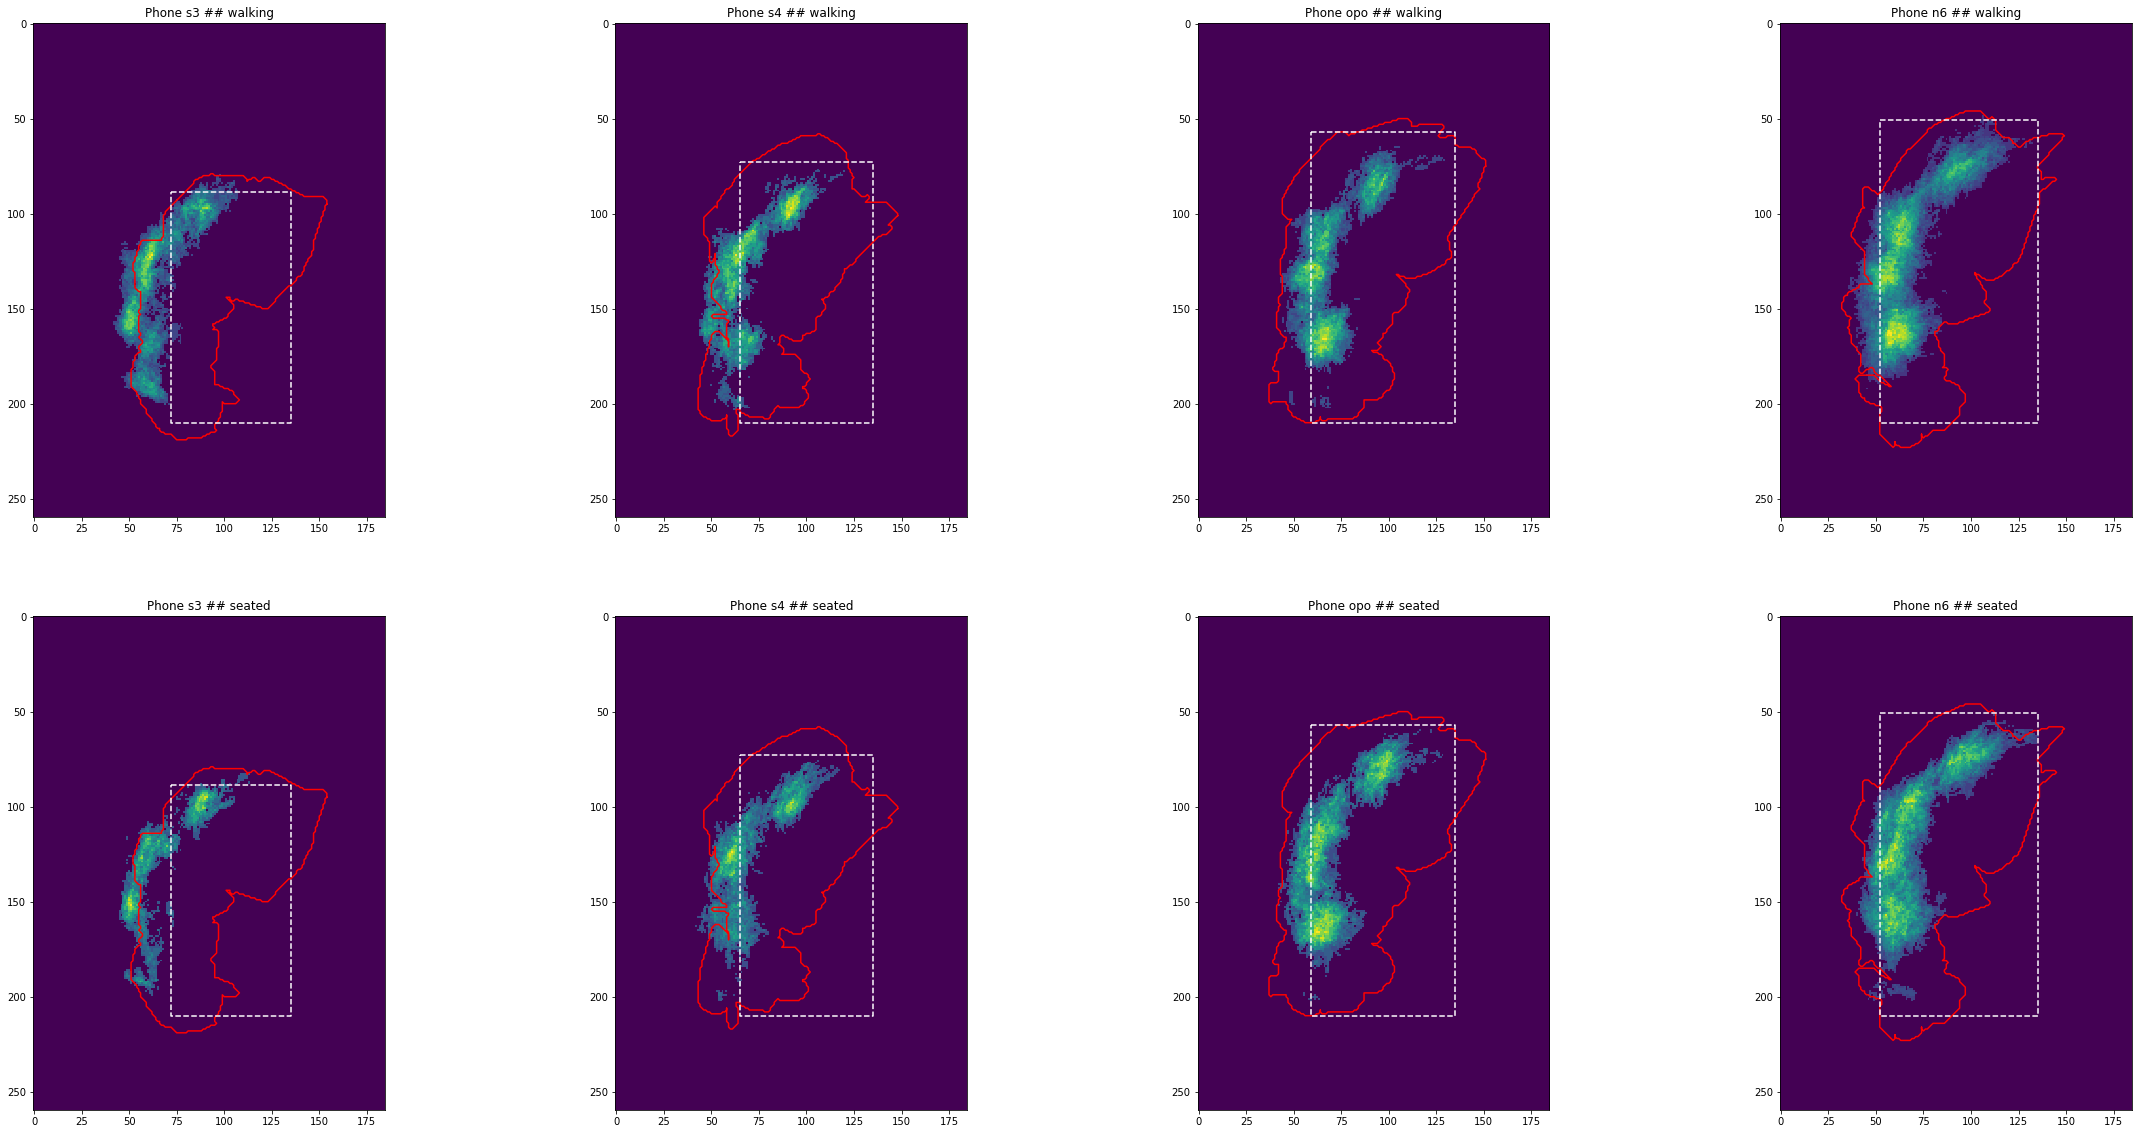

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(40, 20))

for i, cond in enumerate(["walking", "seated"]):

    for d in range(0, len(devices)):
        device = devices[d]
                 
        joint = "Fn"

        total_img = df[(df.Device == device) & (df.Joint == joint) & (df.Finger!= "Thumb") & (df.Condition == cond)].FilledContour.sum()
        #print(device + " "+ str(len(total_img))+"#######" +str(len(total_img[0])))
        # filter total_img to spots that are touched at least by 4 participants
        total_img[total_img < 4] = 0
        contour = getContourFromImg(comfortable_areas_paper[d].T,0)
        ax[i][d].plot(contour[:, 0], contour[:, 1], c = "r")
        #contour = getContourFromImg(total_img.T, 2)
        ax[i][d].imshow(total_img)
        ax[i][d].set_title("Phone %s ## %s"%(device,cond))

        # draw device corners
        x, y = getDeviceCorners(device)
        line, = ax[i][d].plot(x, y, 'w--')

# Comfortable areas
Comfortable areas for all fingers on four different devices. 

For each comfortable area made by a participant with a specific finger on a device, we 1) filtered out noise by using scikit-image's implementation to remove single points and 2) dilate and erode the image to fill little gaps between touched points. We then determined the contour of each participant's comfortable area, filled them (and thus making the image binary) and added them up to an image representing the contours of all participants for a specicic finger and device. Using thresholding, we then removed all pixels with a value lower than 25% of all participants (4). This effectively filters out the trajectories of the participants with the largest hand/finger and favorable grip to reach certain areas that the majority cannot reach. 


# ANOVA 

In [10]:
%%time
dfs=[]
for phone in devices:
    help_dict = {}
    help_df = pd.DataFrame()
    for cond in ["walking", "seated"]:
        test_arr = 0
        for f in fingers:
            temp_df = df[(df.Joint == "Fn")&(df.Device == phone.lower())&(df.Condition == cond)&(df.Finger == f)]
            participants = temp_df.Participant.unique()
            for p in participants:
                part_df = temp_df[temp_df.Participant == p]
                help_arr = 0
                for index, row in part_df.iterrows():
                    help_dict["PId"] = row["Participant"]
                    help_dict["Cond"] = row["Condition"]
                    
                    help_dict["Phone"] = row["Device"]
                    help_arr +=row["NewComfArea"]
                    test_arr+=row["NewComfArea"]
                help_dict["Finger"] = f
#                 help_arr[help_arr>0] = 1
                
                ## thresholding 
                threshold = 0
                help_arr[help_arr <= threshold] = 0
                help_arr[help_arr > threshold] = 1
                ## thresholding
                
                help_dict["TouchedArea"] = help_arr.sum()
                help_df = help_df.append(help_dict, ignore_index=True)
    help_df["PId"] = help_df.PId.astype(int)
    help_df["TouchedArea"] = help_df.TouchedArea.astype(int)
    #print("Exporting Anova_Areas_%s.csv"%phone)
    #help_df.sort_values("PId").to_csv("./AnovaFinger/Anova_Areas_%s.csv"%phone,index=False)
    dfs.append(help_df)

CPU times: user 2.67 s, sys: 38.5 ms, total: 2.71 s
Wall time: 2.7 s


In [11]:
pd.concat(dfs).sort_values("PId").to_csv("./out/Anova_Areas_total_v2.csv", index=False)

# Figure 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount

seated, Thumb, r, p [.877, .123]
seated, Index, r, p [-.945, .055]
seated, Middle, r, p [-.187, .813]
seated, Ring, r, p [.811, .189]
seated, Little, r, p [.194, .806]
walking, Thumb, r, p [.940, .060]
walking, Index, r, p [-.875, .125]
walking, Middle, r, p [.942, .058]
walking, Ring, r, p [.921, .079]
walking, Little, r, p [.841, .159]


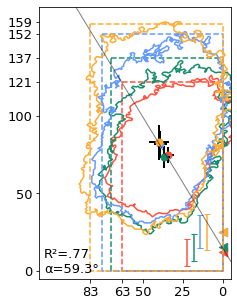

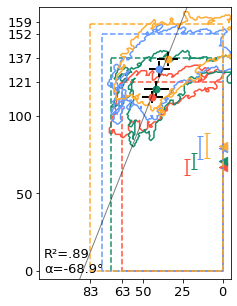

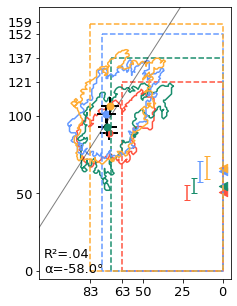

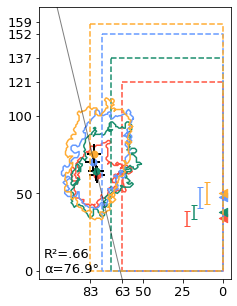

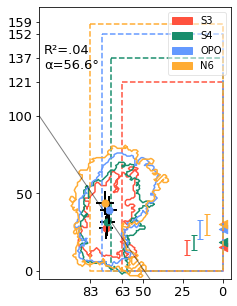

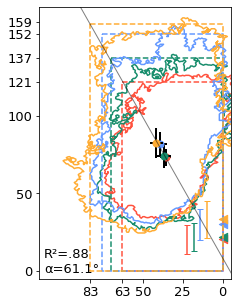

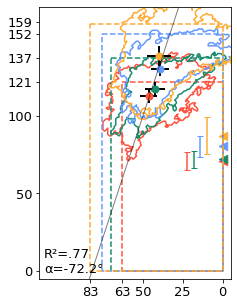

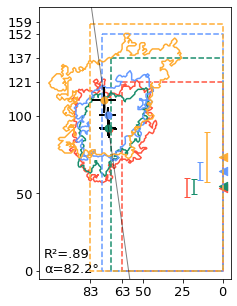

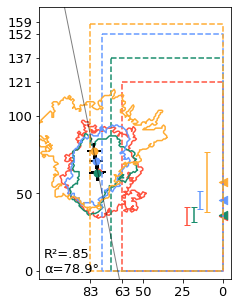

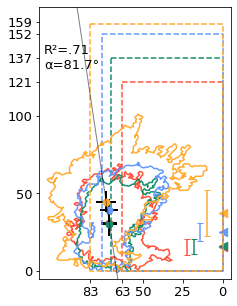

In [12]:
ratio = (140.0 - 20.0) / (215.0 - 40.0)

fig = []
ax = []

for device in range(10):
    fig1, ax1 = plt.subplots(1, figsize=( 5.0*ratio, 5))
    fig.append(fig1)
    ax.append(ax1)

centroids = [[[], [], [], [], []],
            [[], [], [], [], []]]

contour_sizes = [[[], [], [], [], []],
                 [[], [], [], [], []]]

mcp_centroids = [[[], [], [], [], []],
                 [[], [], [], [], []]]

index_mcp_centroids = [[],[]]
centers_all = [[],[]]
for i, cond in enumerate(["seated","walking"]):
    for d in range(0, len(devices)):
        device = devices[d]
        mean_points = []

        for f in range(0, len(fingers)):
            finger =fingers[f] 
            joint = "Fn"

            df_filtered = df[(df.Device == device) & (df.Finger == finger) & (df.Joint == joint) & (df.Condition == cond)]
            total_img = df_filtered.NewComfArea.sum()

            # filter total_img to spots that are touched at least by 2 participants
            #total_img[total_img < int(len(df_filtered) / 4)] = 0

            # calculate contour size
            contour_sizes[i][f].append(len(total_img[total_img > 0]))

            contour = getContourFromImg(total_img.T, 1)

            ax[f+(len(fingers)*i)].plot(contour[:, 0], contour[:, 1], color=colors[d])
            df_mcp = df[(df.Device == device) & (df.Finger == finger) & (df.Joint == "MCP")&(df.Condition == cond)]

            centers = []
            y_s = []
            for index, row in df_mcp.iterrows():
                img = row.NewComfArea
                nz = np.argwhere(img.T) 
                x = nz[:, 0]
                y = nz[:, 1]
                y_s.append(y)
                center_x = x.mean()
                center_y = y.mean()
                if (not np.isnan(center_x) and not np.isnan(center_y)):
                    centers.append([center_x, center_y])
                    centers_all.append([center_x, center_y])
                #if (not np.isnan(center_x) and not np.isnan(center_y)):
                #    stds.append([std_x,std_y])
            conc = []
            for item in y_s:
                ls = item.tolist()
                conc+=ls

            centers = np.array(centers)
            if (finger == "Index"):
                index_mcp_centroids.append(centers[:, 1].mean())
            
            mcp_centroids[i][fingers.index(finger)].append(centers[:, 1].mean())
            
            ax[f+(len(fingers)*i)].scatter(heatmap_size_x - 50, centers[:, 1].mean(), marker="<", color=colors[d], s=70)
            #ax[f].vlines(x = heatmap_size_x - (54 +((d+1)*2)),ymin = centers[:, 1].mean() -np.std(conc)  , ymax=centers[:, 1].mean() + np.std(conc), color = colors[d]  )
            ax[f+(len(fingers)*i)].errorbar(x = heatmap_size_x - (80 - ((d+2)*4)), y = centers[:, 1].mean(), yerr=np.std(conc)/2, capsize = 3, color = colors[d])
            #ax[f].vlines(x = 50 ,ymin = 40  , ymax=80)

            # Mean positions
            cx_mean = df_filtered.Center_X.mean()
            cy_mean = df_filtered.Center_Y.mean()
            cx_std = df_filtered.Center_X.std()
            cy_std = df_filtered.Center_Y.std()
            
            #print("%s Center %s" % (device, finger))
            #print((cx_mean, cy_mean))
            centroids[i][f].append([cx_mean, cy_mean])

            ax[f+(len(fingers)*i)].plot([cx_mean - cx_std/2.0, cx_mean + cx_std/2.0], [cy_mean, cy_mean], 'k-', lw=2)
            ax[f+(len(fingers)*i)].plot([cx_mean, cx_mean], [cy_mean - cy_std/2.0, cy_mean + cy_std/2.0], 'k-', lw=2)
            ax[f+(len(fingers)*i)].plot(cx_mean, cy_mean, '-', color=colors[d], markersize=7)
            ax[f+(len(fingers)*i)].plot(df_filtered.Center_X.mean(), df_filtered.Center_Y.mean(), 'o', color=colors[d], markersize=7)
            #ax[f].set_title(device + " (" + finger + "_" + joint + ")")
            
            ################################ DRAWING BORDERS, SETTING TICKS AND LIMS
            rb_edge = (heatmap_size_x - 50, heatmap_size_y - 50)
            device_width_px = get_device_size(device)[0] / 0.001
            device_height_px = get_device_size(device)[1] / 0.001
            x = [rb_edge[0] - device_width_px, rb_edge[0], rb_edge[0], rb_edge[0] - device_width_px, rb_edge[0] - device_width_px]
            y = [rb_edge[1] - device_height_px, rb_edge[1] - device_height_px, rb_edge[1], rb_edge[1], rb_edge[1] - device_height_px]
            line, = ax[f+(len(fingers)*i)].plot(x, y, 'k--', c= colors[devices.index(device)])
            n6_size = get_device_size('n6')*1000
            opo_size = get_device_size('opo')*1000
            s4_size = get_device_size('s4')*1000
            s3_size = get_device_size('s3')*1000
            ax[f+(len(fingers)*i)].set_xlim(20, 140)
            ax[f+(len(fingers)*i)].set_xticks([heatmap_size_x-device_width_px-50,
                                             heatmap_size_x-s3_size[0]-50,
                                             heatmap_size_x-100,
                                             heatmap_size_x-50-25,
                                             heatmap_size_x-50])
            ax[f+(len(fingers)*i)].set_xticklabels([int(n6_size[0]), int(s3_size[0]), "50", "25", "0"])
            ax[f+(len(fingers)*i)].set_ylim(215, 40)
            ax[f+(len(fingers)*i)].set_yticks([heatmap_size_y-device_height_px-51,
                                             heatmap_size_y-opo_size[1]-50,
                                             heatmap_size_y-s4_size[1]-50,
                                             heatmap_size_y-s3_size[1]-50,
                                             heatmap_size_y-150,
                                             heatmap_size_y-100,
                                             heatmap_size_y-50])
            ax[f+(len(fingers)*i)].set_yticklabels([int(n6_size[1]), int(opo_size[1]), int(s4_size[1]), int(s3_size[1]), "100", "50", "0"])
            ax[f+(len(fingers)*i)].tick_params(axis='both', which='major', labelsize=13)
            ax[f+(len(fingers)*i)].tick_params(axis='both', which='minor', labelsize=13)
            ################################ DRAWING BORDERS, SETTING TICKS AND LIMS
            red_patch = matplotlib.patches.Patch(color="#FF523E", label='S3')
            green_patch = matplotlib.patches.Patch(color="#188D6C", label='S4')
            blue_patch = matplotlib.patches.Patch(color="#6499FF", label='OPO')
            yellow_patch = matplotlib.patches.Patch(color="#FFAC33", label='N6')
            
            if (f+(len(fingers)*i)) == 4:
                ax[f+(len(fingers)*i)].legend(handles=[red_patch, green_patch, blue_patch, yellow_patch], loc='upper right', framealpha=0.5)


# mcp centroids
# for f in range(len(fingers)):
#     for d in range(len(index_mcp_centroids)):
#         ax[f].scatter(heatmap_size_x - 50, index_mcp_centroids[d], marker="<", color=colors[d], s=80)
        
centroids = np.array(centroids)
for i,c in enumerate(["seated","walking"]):
    for f in range(len(fingers)):
        finger =fingers[f] 

        mp = centroids[i][f]
        x = mp[:, 0]
        y = mp[:, 1]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
        print("%s, %s, r, p [%s, %s]" % (c,finger, ("%.3f"%r_value).replace("0.","."), ("%.3f"%p_value).replace("0.",".")))
        r_squared = r_value**2

        grad_angle = math.degrees(math.atan(slope))

        pfit = [slope, intercept]
        xx1 = np.linspace(0, 200, 50)
        yy1 = intercept + slope * xx1
        #yy1 = pfit(xx1)
        
        ax[f+(len(fingers)*i)].plot(xx1, yy1, linewidth=1, color="black", alpha=0.5)

        text_y_pos = 211
        if (f == 4):
            text_y_pos = 80
            
        r2_string = u'R²='+str(np.round(r_squared, 2)).replace("0.", ".")
        alpha_string = u'α='+str(np.round(grad_angle, 1)).replace("0.", ".") + "°"
        ax[f+(len(fingers)*i)].text(23, text_y_pos, r2_string + "\n" + alpha_string, fontsize=13)  
#         ax[f+(len(fingers)*i)].text(23, text_y_pos + 9, , fontsize=10)  

In [13]:
df_filtered.Center_X.mean()

61.951553045132506

In [14]:
print( "Exporting....")            
for y,cond in enumerate(["seated","walking"]):
    for f in fingers:
        text_y_pos = 58
        text = "Back"
        if (fingers.index(f) == 0):
            text = "Front"
        i = fingers.index(f)
        cndLbls = ["Sitting", "Walking"]
        ax[i+(len(fingers)*y)].text(23, text_y_pos, text + "\n" + cndLbls[y], fontsize=13)  

        
        filename =  "./figures/gripareas_"+cond+"_"+ f.lower() + ".pdf"
        print (filename)
        fig[i+(len(fingers)*y)].savefig(filename, bbox_inches='tight')

Exporting....
./figures/gripareas_seated_thumb.pdf
./figures/gripareas_seated_index.pdf
./figures/gripareas_seated_middle.pdf
./figures/gripareas_seated_ring.pdf
./figures/gripareas_seated_little.pdf
./figures/gripareas_walking_thumb.pdf
./figures/gripareas_walking_index.pdf
./figures/gripareas_walking_middle.pdf
./figures/gripareas_walking_ring.pdf
./figures/gripareas_walking_little.pdf


# Figure 6

s3 walking 0.45438574476094873 3621.0
s4 walking 0.48103409347482506 4261.0
opo walking 0.4336920831813207 4755.0
n6 walking 0.25635255508673227 2734.0
s3 seated 0.6028359894591542 4804.0
s4 seated 0.4841950778956875 4289.0
opo seated 0.4090660342940533 4485.0
n6 seated 0.35939990623534923 3833.0
./figures/union_walking_s3.pdf
./figures/union_walking_s4.pdf
./figures/union_walking_opo.pdf
./figures/union_walking_n6.pdf
./figures/union_seated_s3.pdf
./figures/union_seated_s4.pdf
./figures/union_seated_opo.pdf
./figures/union_seated_n6.pdf


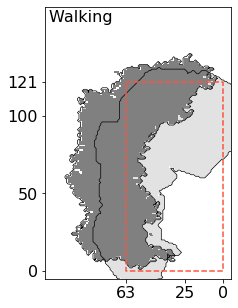

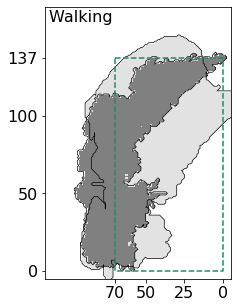

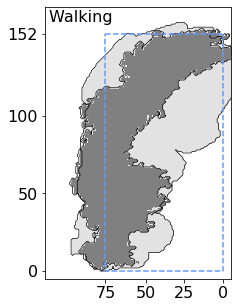

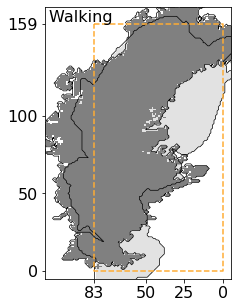

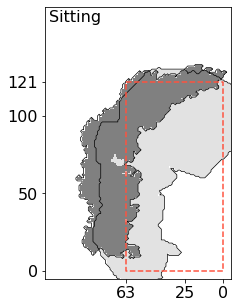

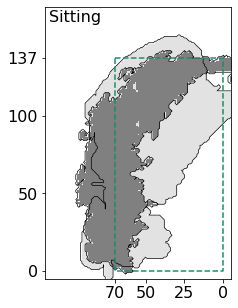

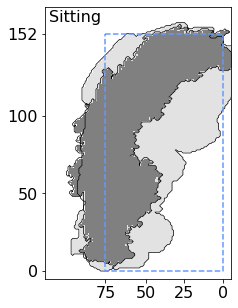

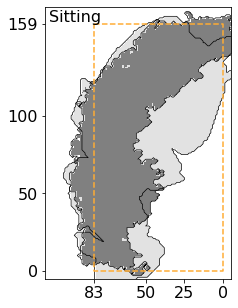

In [15]:
ratio = (140.0 - 20.0) / (215.0 - 40.0)
fig = []
ax = []

safe_areas_cm = []
safe_areas_per = []

for i in range(0,8):
    fig1, ax1 = plt.subplots(1, figsize=( 5.0*ratio, 5))
    fig.append(fig1)
    ax.append(ax1)
for i,c in enumerate(["walking", "seated"]):
    for d in range(0, len(devices)):
        device = devices[d]
        union_img = np.zeros((260, 185))

        for f in range(1, len(fingers)):
            finger =fingers[f] 
            joint = "Fn"

            df_filtered = df[(df.Device == device) & (df.Finger == finger) & (df.Joint == joint) & (df.Condition == c)]
            total_img = df_filtered.NewComfArea.sum()

            contour = getContourFromImg(total_img, 1)
            filled = fillContour(contour, total_img.shape)
            union_img = union_img + filled


        union_img[union_img > 0] = 4

        
        contour_huy = comfortable_areas_paper[d]
        contour_huy[contour_huy>0] = 2
        
        diff = contour_huy+union_img
        diff[diff >= 4] = 6

        n6_size = get_device_size('n6')*1000
        opo_size = get_device_size('opo')*1000
        s4_size = get_device_size('s4')*1000
        s3_size = get_device_size('s3')*1000
        ax[(i*4)+d].set_xlim(20, 140)
        
        x_ticks = [heatmap_size_x-n6_size[0]-50,
                                         heatmap_size_x-opo_size[0]-50,
                                         heatmap_size_x-s4_size[0]-50,
                                         heatmap_size_x-s3_size[0]-50,
                                         ]
        x_ticks_label = [int(n6_size[0]), int(opo_size[0]), int(s4_size[0]), int(s3_size[0])]

        xticks_arr = [x_ticks[3-d], heatmap_size_x-100, heatmap_size_x-75, heatmap_size_x-50]
        xticks_label_arr = [x_ticks_label[3-d], "50", "25", "0"]
        
        if (d == 0):
            xticks_label_arr.remove("50")
            xticks_arr.remove(heatmap_size_x-100)
        
        ax[(i*4)+d].set_xticks(xticks_arr)
        ax[(i*4)+d].set_xticklabels(xticks_label_arr)
        ax[(i*4)+d].set_ylim(215, 40)
        
        device_width_px = get_device_size(device)[0] / 0.001
        device_height_px = get_device_size(device)[1] / 0.001
            
        y_ticks = [heatmap_size_y-device_height_px-50,
                                         heatmap_size_y-opo_size[1]-50,
                                         heatmap_size_y-s4_size[1]-50,
                                         heatmap_size_y-s3_size[1]-50,
                                         heatmap_size_y-50]
        y_ticks_label = [int(n6_size[1]), int(opo_size[1]), int(s4_size[1]), int(s3_size[1]), "0"]
        ax[(i*4)+d].set_yticks([y_ticks[3-d], heatmap_size_y-150, heatmap_size_y-100, heatmap_size_y-50])
        ax[(i*4)+d].set_yticklabels([y_ticks_label[3-d], "100", "50", "0"])
           
        ax[(i*4)+d].imshow(diff, cmap="Greys", alpha=0.5)
        
        cnfLbl = ["Walking", "Sitting"]
        ax[(i*4)+d].text(0.022, .99, cnfLbl[i], transform=ax[(i*4)+d].transAxes, fontsize=16,
    verticalalignment='top')
        ax[(i*4)+d].tick_params(axis='both', which='major', labelsize=16)
        ax[(i*4)+d].tick_params(axis='both', which='minor', labelsize=16)

        # calculating the overlap rate
        # overlap:
        overlap = contour_huy+union_img
        overlap[overlap==4] = 2
        overlap[overlap!=6] = 0
        overlap[overlap == 6] = 1
        ch_temp = np.array(contour_huy, copy=True)
        ch_temp[ch_temp == 2] = 1
        
        
        print(devices[d], c, 1 - (overlap.sum() / ch_temp.sum()), ch_temp.sum() - overlap.sum())
        safe_areas_cm.append(ch_temp.sum() - overlap.sum())
        safe_areas_per.append(1 - (overlap.sum() / ch_temp.sum()))
        
        
        temp_diff = np.array(diff, copy=True)
        temp_diff[temp_diff < 6] = 0
        contour_huy_cont = getContourFromImg(temp_diff.T,0)
        ax[(i*4)+d].plot(contour_huy_cont[:, 0], contour_huy_cont[:, 1], c="black", linewidth=0.7)
        contour_huy_cont1 = getContourFromImg(comfortable_areas_paper[d].T,0)
        ax[(i*4)+d].plot(contour_huy_cont1[:, 0], contour_huy_cont1[:, 1], c="black", linewidth=0.7)
        
        # draw device corners
        x, y = getDeviceCorners(device)
        line, = ax[(i*4)+d].plot(x, y, 'w--',c = colors[d])

for y,c in enumerate(["walking", "seated"]):
    for d in devices:
        i = devices.index(d)
        filename =  "./figures/union_" +c+"_"+ d + ".pdf"
        print (filename)
        fig[(y*4)+i].patch.set_facecolor('white')
        fig[(y*4)+i].savefig(filename, bbox_inches='tight')

In [16]:
print("[Walking] AVG cm²:", np.array(safe_areas_cm[:4]).mean())
print("[Walking] AVG %:", np.array(safe_areas_per[:4]).mean())

print("[Seated] AVG cm²:", np.array(safe_areas_cm[4:]).mean())
print("[Seated] AVG %:", np.array(safe_areas_per[4:]).mean())

[Walking] AVG cm²: 3842.75
[Walking] AVG %: 0.40636611912595666
[Seated] AVG cm²: 4352.75
[Seated] AVG %: 0.4638742519710611


# Percentages of comfortable areas touched

walking - s3 ## Thumb -> Percent of Finger Comf Area touched: 62.38 %
walking - s3 ## Index -> Percent of Finger Comf Area touched: 37.97 %
walking - s3 ## Middle -> Percent of Finger Comf Area touched: 41.21 %
walking - s3 ## Ring -> Percent of Finger Comf Area touched: 41.51 %
walking - s3 ## Little -> Percent of Finger Comf Area touched: 62.49 %
walking - s4 ## Thumb -> Percent of Finger Comf Area touched: 65.34 %
walking - s4 ## Index -> Percent of Finger Comf Area touched: 28.90 %
walking - s4 ## Middle -> Percent of Finger Comf Area touched: 38.76 %
walking - s4 ## Ring -> Percent of Finger Comf Area touched: 35.07 %
walking - s4 ## Little -> Percent of Finger Comf Area touched: 64.03 %
walking - opo ## Thumb -> Percent of Finger Comf Area touched: 71.27 %
walking - opo ## Index -> Percent of Finger Comf Area touched: 34.16 %
walking - opo ## Middle -> Percent of Finger Comf Area touched: 37.53 %
walking - opo ## Ring -> Percent of Finger Comf Area touched: 45.31 %
walking - opo 

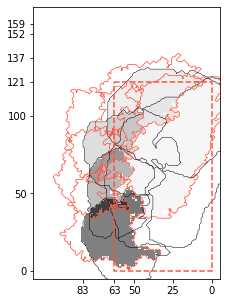

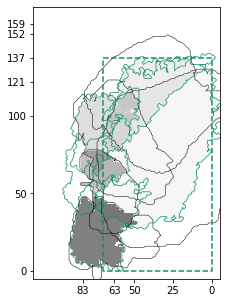

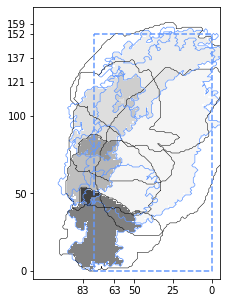

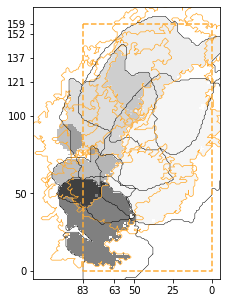

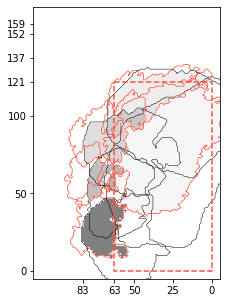

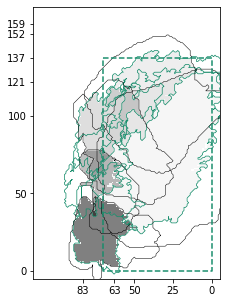

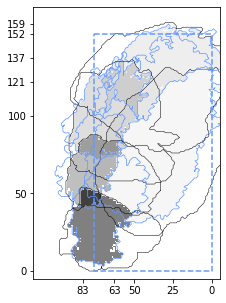

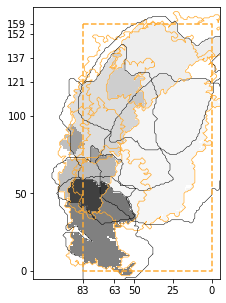

In [17]:
finger_dict= {"walking":{"Thumb":[], "Index":[], "Middle":[], "Ring":[], "Little":[]},
              "seated":{"Thumb":[], "Index":[], "Middle":[], "Ring":[], "Little":[]}}
phone_dict={"walking":{"s3":[], "s4":[], "opo":[], "n6":[]},
              "seated":{"s3":[], "s4":[], "opo":[], "n6":[]}}
fig = []
ax = []
for i in range(0,8):
    fig1, ax1 = plt.subplots(1, figsize=( 5.0*ratio, 5))
    fig.append(fig1)
    ax.append(ax1)
    
for i,c in enumerate(["walking", "seated"]):
    for d in range(0, len(devices)):
        device = devices[d]
        
        
        for f in range(5):
            union_img = np.zeros((260, 185))
            finger =fingers[f] 
            joint = "Fn"

            df_filtered = df[(df.Device == device) & (df.Finger == finger) & (df.Joint == joint) & (df.Condition == c)]
            total_img = df_filtered.NewComfArea.sum()
            total_img[total_img < 2] = 0
            contour = getContourFromImg(total_img, 1)
            filled = fillContour(contour, total_img.shape)
            
            union_img = union_img + filled 
            union_img[union_img>0] = 4
            
            contour_touched = getContourFromImg(filled.T,0)
            ax[(i*4)+d].plot(contour_touched[:, 0], contour_touched[:, 1], c=colors[d], linewidth=0.75)
            
            
            comf_area_finger = finger_comfortable_areas_paper[f][d]
            comf_area_finger[comf_area_finger>0] = 2
            contour_huy_cont1 = getContourFromImg(comf_area_finger.T,0)
            ax[(i*4)+d].plot(contour_huy_cont1[:, 0], contour_huy_cont1[:, 1], c="black", linewidth=0.5)
             
            diff = comf_area_finger + union_img
            inside_finger = diff
            inside_finger[inside_finger!=6] = 0
            inside_finger[inside_finger>0]=1
            comf_area_finger[comf_area_finger>0] = 1
            print("%s - %s ## %s -> Percent of Finger Comf Area touched: %s %%"%(c,device,finger, "%.2f"%((inside_finger.sum()/comf_area_finger.sum())*100)))
            ax[(i*4)+d].imshow(diff,cmap="Greys", alpha=0.5)
            finger_dict[c][finger].append(((inside_finger.sum()/comf_area_finger.sum())*100))
            phone_dict[c][device].append(((inside_finger.sum()/comf_area_finger.sum())*100))
            

        n6_size = get_device_size('n6')*1000
        opo_size = get_device_size('opo')*1000
        s4_size = get_device_size('s4')*1000
        s3_size = get_device_size('s3')*1000
        ax[(i*4)+d].set_xlim(20, 140)
        ax[(i*4)+d].set_xticks([heatmap_size_x-device_width_px-50,
                                         heatmap_size_x-s3_size[0]-50,
                                         heatmap_size_x-100,
                                         heatmap_size_x-50-25,
                                         heatmap_size_x-50])
        ax[(i*4)+d].set_xticklabels([int(n6_size[0]), int(s3_size[0]), "50", "25", "0"])
        ax[(i*4)+d].set_ylim(215, 40)
        ax[(i*4)+d].set_yticks([heatmap_size_y-device_height_px-50,
                                         heatmap_size_y-opo_size[1]-50,
                                         heatmap_size_y-s4_size[1]-50,
                                         heatmap_size_y-s3_size[1]-50,
                                         heatmap_size_y-150,
                                         heatmap_size_y-100,
                                         heatmap_size_y-50])
        ax[(i*4)+d].set_yticklabels([int(n6_size[1]), int(opo_size[1]), int(s4_size[1]), int(s3_size[1]), "100", "50", "0"])
           
       

        
        x, y = getDeviceCorners(device)
        line, = ax[(i*4)+d].plot(x, y, 'w--',c = colors[d])


In [18]:
for cond, f_dict in finger_dict.items():
    for finger, values in f_dict.items():
        values_arr = np.array(values)
        print("%s## %s - %s , Mean %s , SD %s"%(cond, finger, values_arr.round(2), str(values_arr.mean().round(2)),str(values_arr.std().round(2))))

walking## Thumb - [62.38 65.34 71.27 77.56] , Mean 69.14 , SD 5.82
walking## Index - [37.97 28.9  34.16 46.07] , Mean 36.78 , SD 6.26
walking## Middle - [41.21 38.76 37.53 55.9 ] , Mean 43.35 , SD 7.37
walking## Ring - [41.51 35.07 45.31 64.42] , Mean 46.58 , SD 10.93
walking## Little - [62.49 64.03 59.94 64.95] , Mean 62.85 , SD 1.9
seated## Thumb - [59.34 65.98 72.9  75.23] , Mean 68.36 , SD 6.22
seated## Index - [29.29 30.21 38.06 40.37] , Mean 34.48 , SD 4.81
seated## Middle - [31.52 37.38 46.15 51.34] , Mean 41.6 , SD 7.66
seated## Ring - [15.38 38.61 46.71 62.5 ] , Mean 40.8 , SD 17.01
seated## Little - [33.13 58.04 55.66 61.8 ] , Mean 52.16 , SD 11.2


In [19]:
for cond, f_dict in phone_dict.items():
    for finger, values in f_dict.items():
        values_arr = np.array(values)
        print("%s## %s - %s , Mean %s , SD %s"%(cond, finger, values_arr.round(2), str(values_arr.mean().round(2)),str(values_arr.std().round(2))))

walking## s3 - [62.38 37.97 41.21 41.51 62.49] , Mean 49.11 , SD 10.95
walking## s4 - [65.34 28.9  38.76 35.07 64.03] , Mean 46.42 , SD 15.25
walking## opo - [71.27 34.16 37.53 45.31 59.94] , Mean 49.64 , SD 13.99
walking## n6 - [77.56 46.07 55.9  64.42 64.95] , Mean 61.78 , SD 10.47
seated## s3 - [59.34 29.29 31.52 15.38 33.13] , Mean 33.73 , SD 14.27
seated## s4 - [65.98 30.21 37.38 38.61 58.04] , Mean 46.04 , SD 13.58
seated## opo - [72.9  38.06 46.15 46.71 55.66] , Mean 51.89 , SD 11.89
seated## n6 - [75.23 40.37 51.34 62.5  61.8 ] , Mean 58.25 , SD 11.72


In [20]:
distances_seated = [[2.54,4.14,4.57,4.93],[0.40,0.78,1.11,1.16],[0.30,0.52,0.60,0.65],[0.23,0.43,0.50,0.56],[0.33,0.57,0.76,0.85]]
distances_walking = [[2.46,3.83,4.32,4.37],[0.32,0.67,0.83,1.13],[0.35,0.47,0.45,0.70],[0.33,0.42,0.45,0.71],[0.44,0.59,0.77,1.12]]
distance_pearson = {"seated":distances_seated,"walking":distances_walking}

dig_sizes = []
for d in devices:
    si = get_device_size(d)

    diagonal = math.sqrt(si[0]**2 + si[1]**2)
    dig_sizes.append(diagonal)
    # print str(diagonal).replace(".", ",")
dig_sizes = np.array(dig_sizes)

for cond, cond_distance in distance_pearson.items():
    for i, finger_dist in enumerate(cond_distance):
        r, p = scipy.stats.pearsonr(dig_sizes, finger_dist)
        r_s = math.pow(r,2)
        print("%s ##  r : %s , r_2 = %s , p: %s "%(c, str("%.3f" % r),str("%.3f" % r_s),str("%.3f" % p)))

seated ##  r : 0.957 , r_2 = 0.916 , p: 0.043 
seated ##  r : 0.988 , r_2 = 0.976 , p: 0.012 
seated ##  r : 0.969 , r_2 = 0.940 , p: 0.031 
seated ##  r : 0.974 , r_2 = 0.948 , p: 0.026 
seated ##  r : 0.997 , r_2 = 0.995 , p: 0.003 
seated ##  r : 0.942 , r_2 = 0.888 , p: 0.058 
seated ##  r : 0.981 , r_2 = 0.962 , p: 0.019 
seated ##  r : 0.840 , r_2 = 0.706 , p: 0.160 
seated ##  r : 0.868 , r_2 = 0.754 , p: 0.132 
seated ##  r : 0.942 , r_2 = 0.888 , p: 0.058 


In [21]:
walking=np.array([0.4748400050194504,0.4926620004515692,0.44655235315578257,0.2684481950304735])
seated=np.array([0.6180198268289623,0.5053059381350192,0.4260306457497264,0.3721518987341772])
walking = (walking -1)*-1
seated = (seated -1)*-1
dig_sizes = []
for d in devices:
    si = get_device_size(d)

    diagonal = math.sqrt(si[0]**2 + si[1]**2)
    dig_sizes.append(diagonal)
    # print str(diagonal).replace(".", ",")
dig_sizes = np.array(dig_sizes)


r, p = scipy.stats.pearsonr(dig_sizes, walking)
r_s = math.pow(r,2)
print("%s ##  r : %s , r_2 = %s , p: %s "%("walking", str("%.3f" % r),str("%.3f" % r_s),str("%.3f" % p)))
r, p = scipy.stats.pearsonr(dig_sizes, seated)
r_s = math.pow(r,2)
print("%s ##  r : %s , r_2 = %s , p: %s "%("seated", str("%.3f" % r),str("%.3f" % r_s),str("%.3f" % p)))

walking ##  r : 0.753 , r_2 = 0.567 , p: 0.247 
seated ##  r : 0.997 , r_2 = 0.995 , p: 0.003 


# Table 1: Grip areas in cm²

In [22]:
fingers_s = {"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]}
fingers_w = {"Thumb":[],"Index":[],"Middle":[],"Ring":[],"Little":[]}
finger_dict = {"walking":fingers_w, "seated":fingers_s}
for i,c in enumerate(["walking", "seated"]):
    temp_dict = finger_dict[c]
    for d in range(0, len(devices)):
        device = devices[d]
        union_img = np.zeros((260, 185))
        
        for f in range(len(fingers)):
            finger =fingers[f] 
            joint = "Fn"

            df_filtered = df[(df.Device == device) & (df.Finger == finger) & (df.Joint == joint) & (df.Condition == c)]
            total_img = df_filtered.NewComfArea.sum()
            total_img[total_img < 2] = 0

            contour = getContourFromImg(total_img, 1)
            filled = fillContour(contour, total_img.shape)
            print("%s ##%s Finger Area %s - %s cm² "%(c, device, finger,str(filled.sum()/100)))
            temp_dict[finger].append(filled.sum()/100)
            union_img = union_img + filled

walking ##s3 Finger Area Thumb - 50.01 cm² 
walking ##s3 Finger Area Index - 21.48 cm² 
walking ##s3 Finger Area Middle - 20.81 cm² 
walking ##s3 Finger Area Ring - 18.35 cm² 
walking ##s3 Finger Area Little - 21.88 cm² 
walking ##s4 Finger Area Thumb - 60.92 cm² 
walking ##s4 Finger Area Index - 15.25 cm² 
walking ##s4 Finger Area Middle - 14.27 cm² 
walking ##s4 Finger Area Ring - 12.26 cm² 
walking ##s4 Finger Area Little - 18.05 cm² 
walking ##opo Finger Area Thumb - 68.79 cm² 
walking ##opo Finger Area Index - 20.8 cm² 
walking ##opo Finger Area Middle - 15.19 cm² 
walking ##opo Finger Area Ring - 12.62 cm² 
walking ##opo Finger Area Little - 22.39 cm² 
walking ##n6 Finger Area Thumb - 88.26 cm² 
walking ##n6 Finger Area Index - 32.94 cm² 
walking ##n6 Finger Area Middle - 30.19 cm² 
walking ##n6 Finger Area Ring - 30.51 cm² 
walking ##n6 Finger Area Little - 41.09 cm² 
seated ##s3 Finger Area Thumb - 46.54 cm² 
seated ##s3 Finger Area Index - 14.43 cm² 
seated ##s3 Finger Area Mi

In [23]:
phones = ["s3","s4","opo","n6"]

for cond, temp_dict in finger_dict.items():
    for finger, values_list in temp_dict.items():
        values_arr = np.array(values_list)
        print("%s## %s - %s , Mean %s , SD %s"%(cond, finger, values_list, str(values_arr.mean().round(2)),str(values_arr.std().round(2))))

walking## Thumb - [50.01, 60.92, 68.79, 88.26] , Mean 67.0 , SD 13.97
walking## Index - [21.48, 15.25, 20.8, 32.94] , Mean 22.62 , SD 6.43
walking## Middle - [20.81, 14.27, 15.19, 30.19] , Mean 20.11 , SD 6.33
walking## Ring - [18.35, 12.26, 12.62, 30.51] , Mean 18.43 , SD 7.38
walking## Little - [21.88, 18.05, 22.39, 41.09] , Mean 25.85 , SD 8.96
seated## Thumb - [46.54, 58.76, 69.19, 86.41] , Mean 65.22 , SD 14.62
seated## Index - [14.43, 17.23, 23.12, 26.82] , Mean 20.4 , SD 4.86
seated## Middle - [12.67, 15.1, 19.28, 22.62] , Mean 17.42 , SD 3.82
seated## Ring - [7.4, 13.88, 15.96, 20.15] , Mean 14.35 , SD 4.6
seated## Little - [12.37, 17.76, 21.93, 27.44] , Mean 19.88 , SD 5.53


In [24]:
dig_sizes = []
for d in devices:
    si = get_device_size(d)

    diagonal = math.sqrt(si[0]**2 + si[1]**2)
    dig_sizes.append(diagonal)
dig_sizes = np.array(dig_sizes)


for cond, temp_dict in finger_dict.items():
    for finger, values_list in temp_dict.items():
        values_arr = np.array(values_list)
        r, p = scipy.stats.pearsonr(dig_sizes, values_arr)
        r_s = math.pow(r,2)
        print("%s## %s - r : %s , r_2 = %s , p: %s "%(cond, finger, str("%.3f" % r),str("%.3f" % r_s),str("%.3f" % p)))

walking## Thumb - r : 0.947 , r_2 = 0.898 , p: 0.053 
walking## Index - r : 0.605 , r_2 = 0.366 , p: 0.395 
walking## Middle - r : 0.398 , r_2 = 0.158 , p: 0.602 
walking## Ring - r : 0.445 , r_2 = 0.198 , p: 0.555 
walking## Little - r : 0.685 , r_2 = 0.470 , p: 0.315 
seated## Thumb - r : 0.971 , r_2 = 0.943 , p: 0.029 
seated## Index - r : 0.983 , r_2 = 0.967 , p: 0.017 
seated## Middle - r : 0.983 , r_2 = 0.967 , p: 0.017 
seated## Ring - r : 0.978 , r_2 = 0.956 , p: 0.022 
seated## Little - r : 0.986 , r_2 = 0.973 , p: 0.014 
